In [164]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [165]:
df = pd.read_csv('HWdata/bank/bank-full.csv')
# df_test = pd.read_csv('HWdata/bank/bank.csv')
# df = pd.read_csv('inclass-data/adult.data', header = None)
# df.columns = ['age', 'workclass', 'fnlwgt', 'edu', 'edu-num', 'marital', 'occupation', 'relationship', 'race', 'sex', 'cap-gain', 'cap-loss','hpw','native country','income']
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [166]:
# Drop features w/ high correlation
df.drop(columns=['pdays','day','month'], inplace=True)

# Replace unknown education with most common
df['education'] = df['education'].replace({'unknown':'secondary'})

# Replace unknown contact with most common
df['job'] = df['job'].replace({'unknown':'blue-collar'})

# Replace unknown contact with most common
df['contact'] = df['contact'].replace({'unknown':'cellular'})

# Drop poutcome since it is mostly unknown
df.drop(columns=['poutcome'], inplace=True)

df.head().value_counts()

age  job           marital  education  default  balance  housing  loan  contact   duration  campaign  previous  y 
33   blue-collar   single   secondary  no       1        no       no    cellular  198       1         0         no    1
     entrepreneur  married  secondary  no       2        yes      yes   cellular  76        1         0         no    1
44   technician    single   secondary  no       29       yes      no    cellular  151       1         0         no    1
47   blue-collar   married  secondary  no       1506     yes      no    cellular  92        1         0         no    1
58   management    married  tertiary   no       2143     yes      no    cellular  261       1         0         no    1
dtype: int64

In [167]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df['campaign']=min_max_scaler.fit_transform(df['campaign'].values.reshape(-1,1))
df['balance']=min_max_scaler.fit_transform(df['balance'].values.reshape(-1,1))
df['age']=min_max_scaler.fit_transform(df['age'].values.reshape(-1,1))
df['duration']=min_max_scaler.fit_transform(df['duration'].values.reshape(-1,1))
df['previous']=min_max_scaler.fit_transform(df['previous'].values.reshape(-1,1))

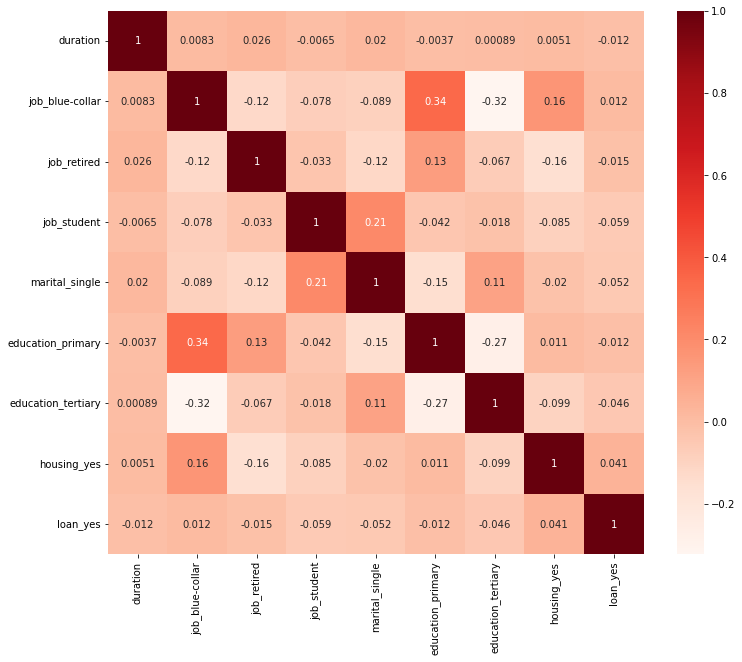

In [168]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
x = pd.get_dummies(x)

selector = SelectKBest(chi2, k=12)
df_new = selector.fit(x, y)

col = selector.get_support(indices=True)
df_new = x.iloc[:,col]

df_new = df_new.drop(columns=['housing_no','marital_married','job_management'])

plt.figure(figsize=(12,10))
cor = df_new.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [169]:
df = pd.concat([df_new, y], axis=1)
df

,duration,job_blue-collar,job_retired,job_student,marital_single,education_primary,education_tertiary,housing_yes,loan_yes,y
0,0.053070,0,0,0,0,0,1,1,0,no
1,0.030704,0,0,0,1,0,0,1,0,no
2,0.015453,0,0,0,0,0,0,1,1,no
3,0.018707,1,0,0,0,0,0,1,0,no
4,0.040260,1,0,0,1,0,0,0,0,no
...,...,...,...,...,...,...,...,...,...,...
45206,0.198658,0,0,0,0,0,1,0,0,yes
45207,0.092721,0,1,0,0,1,0,0,0,yes
45208,0.229158,0,1,0,0,0,0,0,0,yes
45209,0.103294,1,0,0,0,0,0,0,0,no


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.iloc[:,:-1] 
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

logRe = LogisticRegression()

In [171]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [172]:
scores = ["precision", "recall"]


In [173]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

tuned_parameters = [
    {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
]

grid_search = GridSearchCV(
    logRe, tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

/home/azthorax/anaconda3/envs/fra501_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/azthorax/anaconda3/envs/fra501_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/azthorax/anaconda3/envs/fra501_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/azthorax/anaconda3/envs/fra501_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/azthorax/anaconda3/envs/fra501_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1769, in precision_score
    p, _, 

All grid-search results:
precision: nan (±nan), recall: nan (±nan), for {'C': 0.001}
precision: nan (±nan), recall: nan (±nan), for {'C': 0.01}
precision: nan (±nan), recall: nan (±nan), for {'C': 0.1}
precision: nan (±nan), recall: nan (±nan), for {'C': 1.0}
precision: nan (±nan), recall: nan (±nan), for {'C': 10.0}
precision: nan (±nan), recall: nan (±nan), for {'C': 100.0}
precision: nan (±nan), recall: nan (±nan), for {'C': 1000.0}

Models with a precision higher than 0.98:

Out of the previously selected high precision models, we keep all the
the models within one standard deviation of the highest recall model:



ValueError: attempt to get argmin of an empty sequence